# Introducere

În acest laborator, vom explora analiza datelor medicale obținute din imagistica medicală, utilizând două formate de fișiere populare: DICOM și NIFTI. Scopul este să înțelegem specificitatea fiecărui format, să știm cum să manipulăm aceste fișiere și să aplicăm tehnici de bază pentru analiză și preprocesare. Formatele DICOM și NIFTI sunt esențiale în domeniul imagisticii medicale, fiind utilizate pentru a stoca și a gestiona date din investigații precum tomografia computerizată (CT), rezonanța magnetică nucleară (RMN) și tomografia cu emisie de pozitroni (PET).

# DICOM

### Ce este DICOM?
DICOM (Digital Imaging and Communications in Medicine) este un standard internațional pentru stocarea, transmiterea și gestionarea imaginilor medicale. Acesta este utilizat pe scară largă în domeniul imagisticii medicale pentru a asigura compatibilitatea între echipamentele medicale și software-ul utilizat în spitale și alte instituții medicale. Pentru a vizualiza datele puteți folosi 3D Slicer (https://www.slicer.org/)

### Ce informații sunt stocate într-un fișier DICOM?
Fiecare fișier DICOM conține atât date de imagine, cât și metadate asociate. Metadatele includ informații detaliate despre pacient (de exemplu, numele, vârsta), parametrii scanării (de exemplu, tipul aparatului, setările de scanare) și detalii tehnice ale imaginii (de exemplu, rezoluția, dimensiunile voxelilor).
Formatul permite stocarea de imagini 2D, 3D și chiar 4D (imagini secvențiale în timp), fiind utilizat pentru o gamă largă de tipuri de imagistică, cum ar fi RMN, CT și ecografie.
### De ce folosim DICOM?
Înainte de apariția standardului DICOM, radiologii se bazau pe filme radiografice bidimensionale, care erau stocate fizic în dosare. Tehnologia a evoluat, iar DICOM a adus o schimbare majoră, oferind beneficii precum comoditate, economii de costuri și îmbunătățirea îngrijirii pacienților. DICOM a revoluționat radiologia, acoperind multiple modalități imagistice, inclusiv radiografii, tomografie computerizată (CT), imagistică prin rezonanță magnetică (IRM), ecografii.

### Problemele formatului DICOM în utilizarea pentru algoritmi de Machine Learning (ML)
Deși formatul DICOM este un standard în imagistica medicală și are numeroase avantaje, acesta prezintă câteva provocări atunci când este folosit pentru antrenarea algoritmilor de ML. Probleme comune:

1. Inconsistența tag-urilor și metadatelor

De exemplu, informații esențiale despre pacient sau setările scanării pot fi stocate în tag-uri diferite de la un spital la altul, chiar dacă teoretic acestea ar trebui să urmeze același standard. Această lipsă de uniformitate face dificilă extragerea automată a datelor, necesitând preprocesare suplimentară pentru a standardiza aceste informații.

2. Salvarea volumelor 3D ca fișiere multiple DICOM 2D

Volumul 3D al unei scanări medicale (cum ar fi o tomografie computerizată sau un RMN) este de multe ori stocat sub formă de fișiere DICOM separate, fiecare reprezentând o secțiune 2D a imaginii. Aceasta înseamnă că pentru a recrea volumul complet, toate fișierele 2D trebuie să fie încărcate, ordonate și combinate corect.


In [69]:
#!unzip Data.zip

In [70]:
#!pip install pydicom

In [71]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np

# reading data
dicom_file = pydicom.dcmread("test.dcm")

dicom_file

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 194
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108821836759549281694712274169
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008,0000) Group Length                        UL: 430
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.1088218367595492

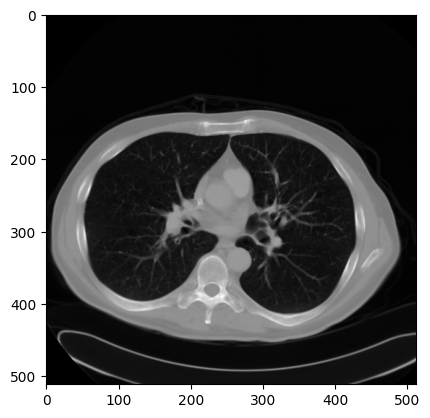

In [72]:
ct = dicom_file.pixel_array
plt.figure()
plt.imshow(ct, cmap='gray')

In [73]:
from pathlib import Path
path = Path("Head_MRI")
slices = list(path.glob("*"))
print(len(slices))
slices

27


[WindowsPath('Head_MRI/MR000000'),
 WindowsPath('Head_MRI/MR000001'),
 WindowsPath('Head_MRI/MR000002'),
 WindowsPath('Head_MRI/MR000003'),
 WindowsPath('Head_MRI/MR000004'),
 WindowsPath('Head_MRI/MR000005'),
 WindowsPath('Head_MRI/MR000006'),
 WindowsPath('Head_MRI/MR000007'),
 WindowsPath('Head_MRI/MR000008'),
 WindowsPath('Head_MRI/MR000009'),
 WindowsPath('Head_MRI/MR000010'),
 WindowsPath('Head_MRI/MR000011'),
 WindowsPath('Head_MRI/MR000012'),
 WindowsPath('Head_MRI/MR000013'),
 WindowsPath('Head_MRI/MR000014'),
 WindowsPath('Head_MRI/MR000015'),
 WindowsPath('Head_MRI/MR000016'),
 WindowsPath('Head_MRI/MR000017'),
 WindowsPath('Head_MRI/MR000018'),
 WindowsPath('Head_MRI/MR000019'),
 WindowsPath('Head_MRI/MR000020'),
 WindowsPath('Head_MRI/MR000021'),
 WindowsPath('Head_MRI/MR000022'),
 WindowsPath('Head_MRI/MR000023'),
 WindowsPath('Head_MRI/MR000024'),
 WindowsPath('Head_MRI/MR000025'),
 WindowsPath('Head_MRI/MR000026')]

In [74]:
mri = []
dcm = []
for x in slices:
    dcm.append(pydicom.dcmread(x))
    mri.append(pydicom.dcmread(x).pixel_array)

for i in dcm:
    print (i.SliceLocation)
    
# daca slice-urile noastre nu sunt in ordine trebuie sa le sortam
"""
dcm = sorted(dcm, key=lambda i: i.SliceLocation)
for x in range(len(dcm)):
    mri.append(dcm[x].pixel_array)
"""

0.0
5.99999663091323
11.9999973042441
17.9999979772582
23.9999946081714
29.9999952815023
35.9999959546749
41.9999963629367
47.9999970362677
53.9999958207213
59.9999962290673
65.9999961939969
71.9999961590453
77.9999962275740
83.9999967682912
89.9999955528687
95.9999960937442
101.999994745866
107.999995419197
113.999995959439
119.999996566542
125.999997173645
131.999997780749
137.999998321624
143.999998928727
149.999999502083
155.999992554172


'\ndcm = sorted(dcm, key=lambda i: i.SliceLocation)\nfor x in range(len(dcm)):\n    mri.append(dcm[x].pixel_array)\n'

In [75]:
def show_plot(to_print,n=3,m=3):
    fig, axes = plt.subplots(n, m, figsize=(15, 15))
    counter = 0 
    for i in range(n):
        for j in range(m):
            axes[i][j].imshow(to_print[counter], cmap="gray")
            axes[i][j].axis('off')
            counter+=1

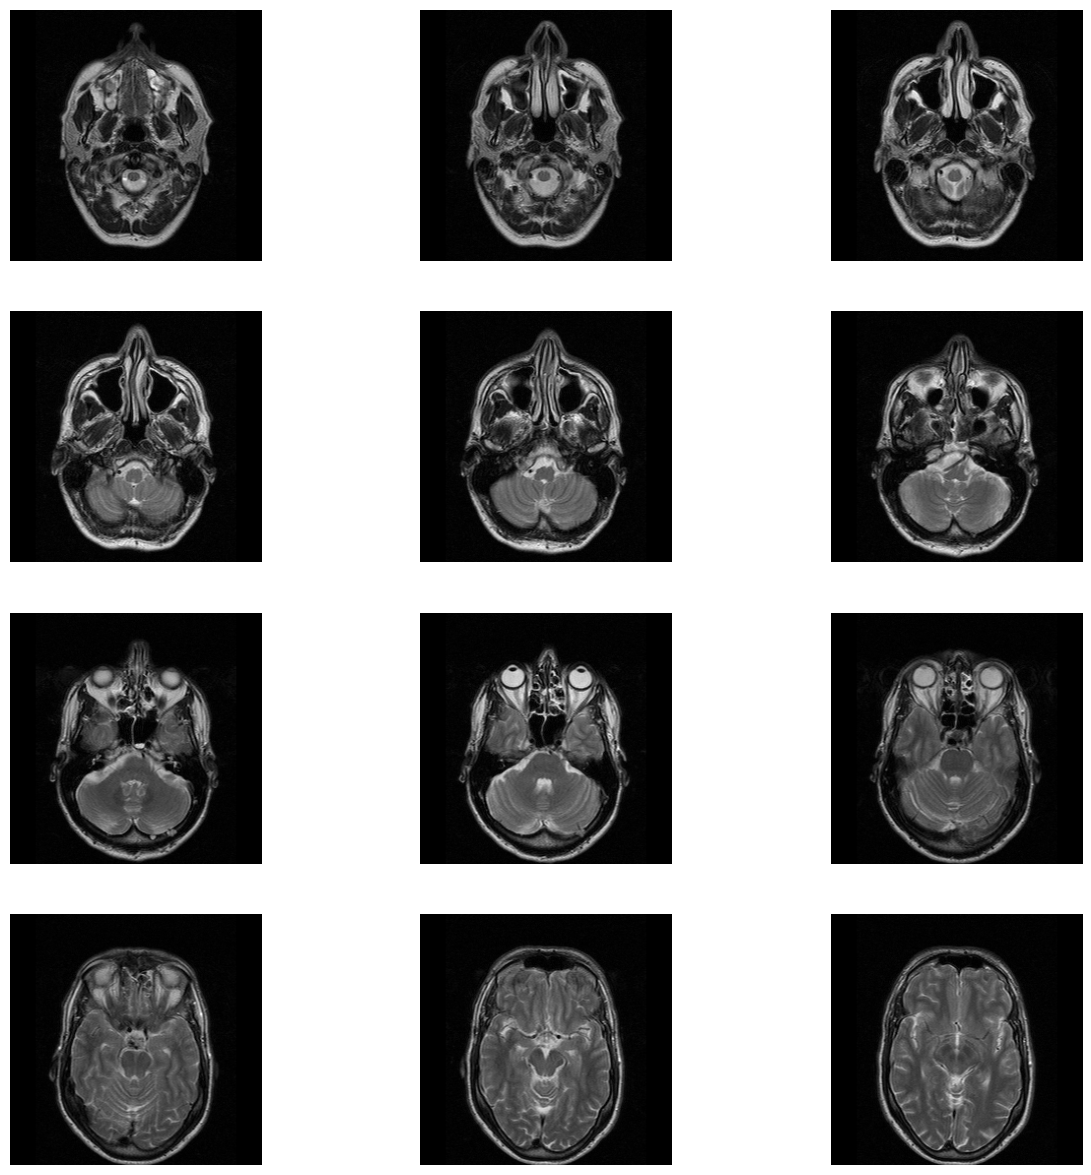

In [76]:
show_plot(mri,4)


In [77]:
#!pip install SimpleITK

### Another way of reading the data and keeping slices sorted

In [78]:
import SimpleITK as sitk

In [79]:
serie_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(path))
print(serie_ids)

('1.3.46.670589.11.0.0.11.4.2.0.12098.5.4500.2015011413262801702',)


In [80]:
file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path), serie_ids[0])
file_names

('Head_MRI/MR000000',
 'Head_MRI/MR000001',
 'Head_MRI/MR000002',
 'Head_MRI/MR000003',
 'Head_MRI/MR000004',
 'Head_MRI/MR000005',
 'Head_MRI/MR000006',
 'Head_MRI/MR000007',
 'Head_MRI/MR000008',
 'Head_MRI/MR000009',
 'Head_MRI/MR000010',
 'Head_MRI/MR000011',
 'Head_MRI/MR000012',
 'Head_MRI/MR000013',
 'Head_MRI/MR000014',
 'Head_MRI/MR000015',
 'Head_MRI/MR000016',
 'Head_MRI/MR000017',
 'Head_MRI/MR000018',
 'Head_MRI/MR000019',
 'Head_MRI/MR000020',
 'Head_MRI/MR000021',
 'Head_MRI/MR000022',
 'Head_MRI/MR000023',
 'Head_MRI/MR000024',
 'Head_MRI/MR000025',
 'Head_MRI/MR000026')

In [81]:
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(file_names)
image_data = series_reader.Execute()
head_mri = sitk.GetArrayFromImage(image_data)
head_mri.shape

(27, 256, 256)

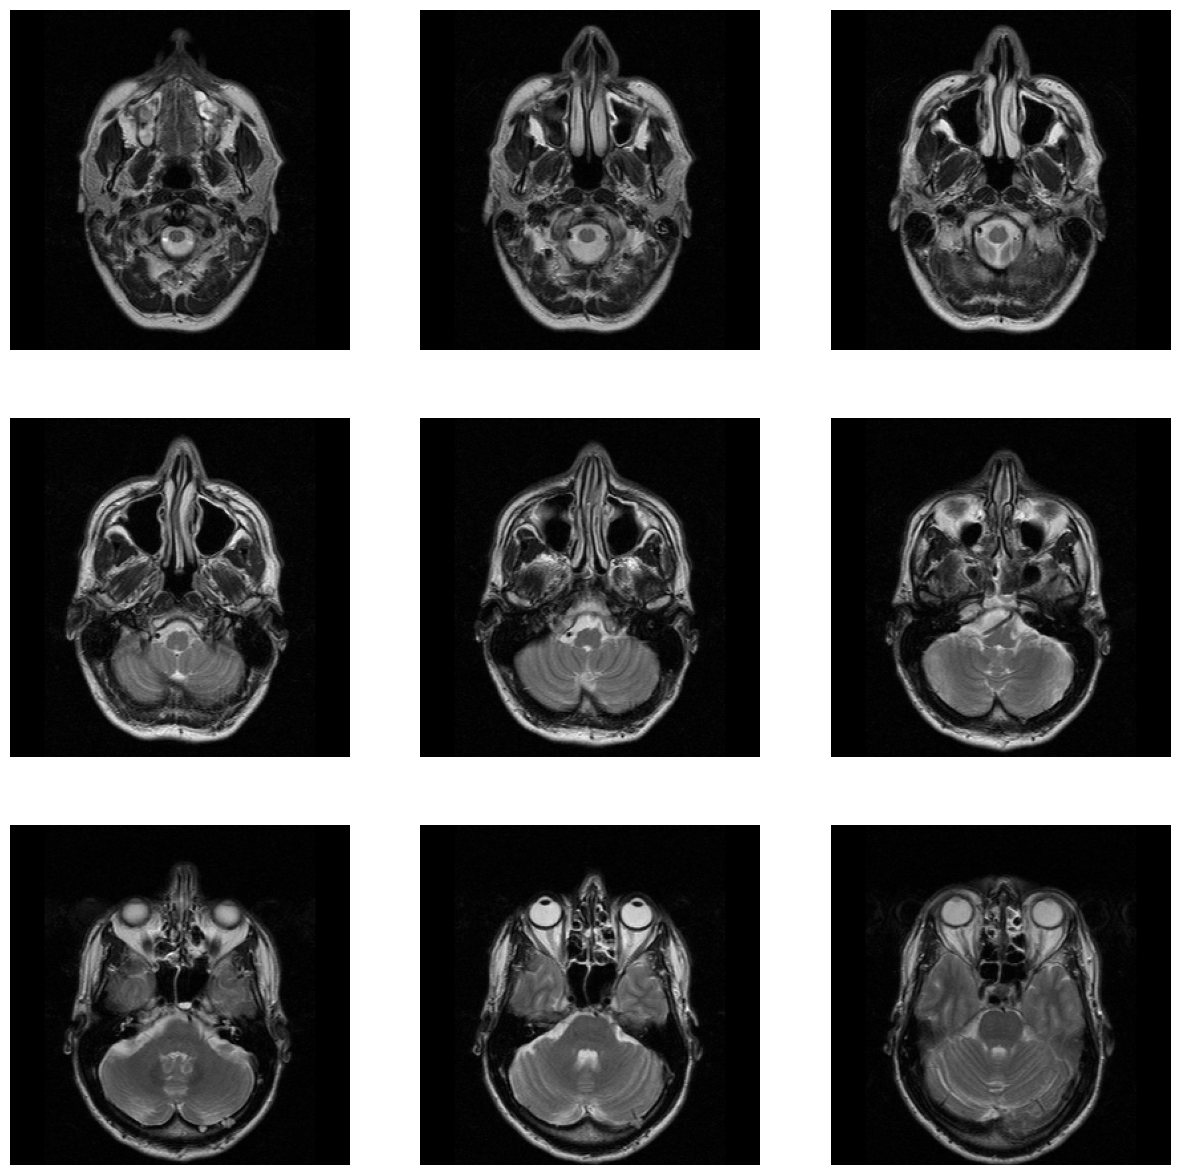

In [82]:
show_plot(head_mri)

# NIFTI 

### Ce este NIFTI?
NIFTI (Neuroimaging Informatics Technology Initiative)  este un format de fișier utilizat în principal pentru imagistica cerebrală și neuroștiințe. Acest format este folosit în aplicații de cercetare pentru a stoca imagini volumetrice (de obicei imagini 3D sau 4D) obținute din RMN.
### Ce informații sunt stocate într-un fișier NIFTI?
Formatul NIFTI este derivat din formatul mai vechi Analyze și adaugă suport pentru metadate suplimentare și o structură standardizată.
Fișierele NIFTI pot fi salvate fie ca un singur fișier .nii, fie ca două fișiere separate: unul pentru datele de imagine (.img) și altul pentru metadate (.hdr).
Permite stocarea de imagini 3D (cum ar fi scanări ale creierului) sau imagini 4D (secvențe temporale de imagini 3D).
### De ce folosim NIFTI?
Este special conceput pentru imagistica volumetrică, fiind utilizat pe scară largă în neuroimagistică și alte domenii de cercetare medicală.
Permite stocarea de imagini 3D și 4D, oferind flexibilitate în analiză și prelucrare. Contine mai putine date decat DICOM si este in general un format mai facil de folosit.

In [83]:
#!pip install nibabel

In [84]:
import nibabel as nib

nifti_img = nib.load('lung_nifti/lung.nii' )
data = nifti_img.get_fdata()
print(f'Dimensiunile volumului: {data.shape}')


Dimensiunile volumului: (512, 512, 129)


In [85]:
def show_nifti_slices(data, n=3, m=3):
    fig, axes = plt.subplots(n, m, figsize=(15, 15))
    for idx, ax in enumerate(axes.flat[:n * m]):
        if idx < data.shape[2]:
            ax.imshow(data[:, :, idx], cmap="gray")
        ax.axis('off')

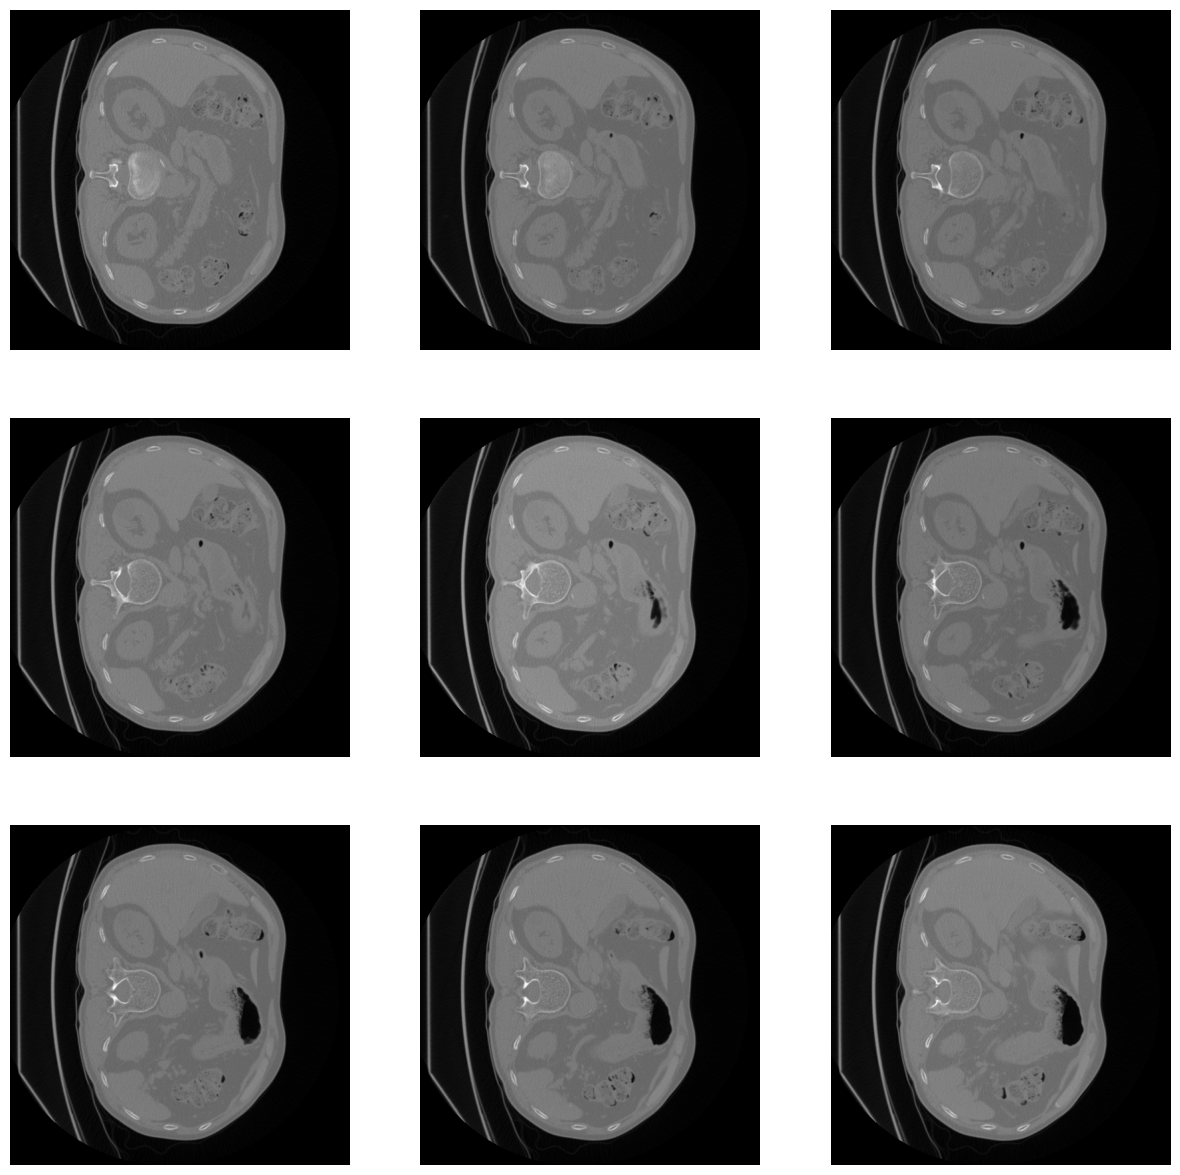

In [86]:
show_nifti_slices(data)

Citirea unei scanări a creierului in format NIFTI

In [87]:
brain_scan = nib.load("brain_scan.nii.gz")
brain_scan_data = brain_scan.get_fdata()

Extragem matricea afină din imagine, care este utilizată pentru a transforma coordonatele voxelilor în coordonate fizice (de exemplu, milimetri). Matricea afină este o matrice de 4x4 care codifică informația despre poziția, orientarea și scara imaginii în spațiul real. https://www.mathworks.com/discovery/affine-transformation.html

In [88]:
affine_matrix = brain_scan.affine
shape = brain_scan.shape

In [89]:
print(affine_matrix, "\n", shape)

[[ 1.89821944e-02 -2.72075552e-03  1.19975281e+00 -9.06798553e+01]
 [-9.27821696e-01  1.32986516e-01  2.45456006e-02  1.02829445e+02]
 [ 1.33014351e-01  9.28015888e-01  5.71511449e-11 -1.14823784e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] 
 (256, 256, 150)


`header.get_zooms()` obține factorii de scalare pentru fiecare axă a imaginii, care reprezintă dimensiunile fizice ale unui voxel în unități de lungime (milimetri).

In [90]:
brain_scan.header.get_zooms()

(0.9375, 0.9375, 1.2000039)

`nib.aff2axcodes` transformă matricea afină într-o reprezentare  sub forma unui tuplu de trei caractere. Aceste caractere indică direcția axei pentru X, Y și Z. În acest caz, orientarea scanării este:

P (Posterior): Prima axă se extinde de la anterior la posterior, adică din față spre spate.

S (Superior): A doua axă merge de la inferior la superior, adică de jos în sus.

R (Right): A treia axă se extinde de la stânga la dreapta.

In [91]:
nib.aff2axcodes(affine_matrix)

('P', 'S', 'R')

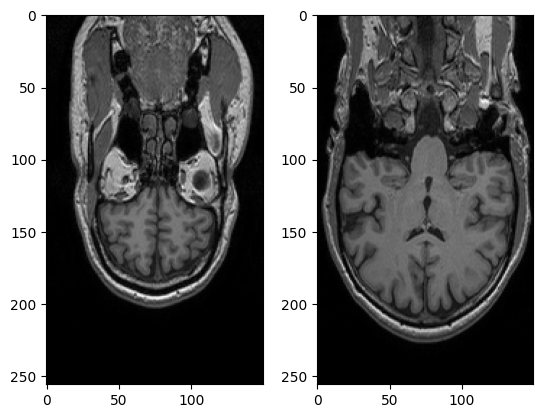

In [92]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_scan_data[60, :, :], cmap="gray")
axis[1].imshow(brain_scan_data[130, :, :], cmap="gray")


1) Vizualizati 2 slice-uri din alta perspectiva

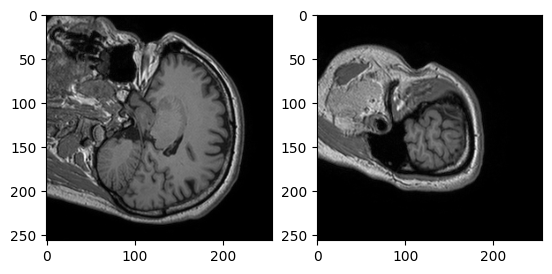

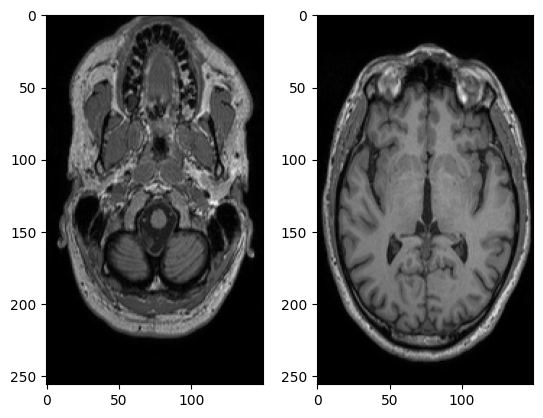

In [93]:
# TO DO 1
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_scan_data[:, :, 60], cmap="gray")
axis[1].imshow(brain_scan_data[:, :, 130], cmap="gray")

fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_scan_data[:, 60, :], cmap="gray")
axis[1].imshow(brain_scan_data[:, 130, :], cmap="gray")

# Preprocesarea datelor


# Resampling

Putem lua în considerare modificarea dimensiunii scanării, deoarece aceasta ar putea fi prea mare pentru sistemul nostru. Totuși, redimensionarea unui volum nu este la fel de simplă precum redimensionarea unei imagini, întrucât este necesară ajustarea dimensiunii voxelilor.

Propunem redimensionarea imaginii RMN a creierului de la (256, 256, 150) la (128, 128, 100).

In [94]:
print(brain_scan.shape)
print(brain_scan.header.get_zooms())

(256, 256, 150)
(0.9375, 0.9375, 1.2000039)


Pentru a realiza acest lucru, puteți utiliza funcția `conform(input, desired_shape, voxel_size)` din `nibabel.processing`, care re-eșantionează imaginea la forma dorită. Este important de menționat că trebuie să modificați dimensiunea voxelilor, deoarece altfel ar fi imposibil să reduceți dimensiunea.

In [95]:
import nibabel.processing

In [96]:
voxel_size = (2, 2, 2)
brain_scan_resized = nibabel.processing.conform(brain_scan, (128, 128, 100), voxel_size, orientation="PSR")
brain_scan_resized_data = brain_scan_resized.get_fdata()

In [97]:
print(brain_scan.shape)
print(brain_scan_resized.shape)
print(brain_scan_resized.header.get_zooms())

(256, 256, 150)
(128, 128, 100)
(2.0, 2.0, 2.0)


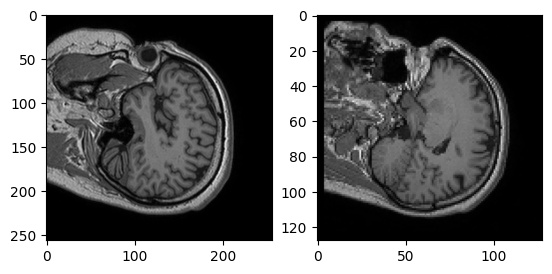

In [98]:
fig, axis = plt.subplots(1, 2)
axis[0].imshow(brain_scan_data[:,:,40], cmap="gray")
axis[1].imshow(brain_scan_resized_data[:,:,40], cmap="gray")

# Normalization

Întrucât tomografiile computerizate (CT) au o scară fixă de la -1000 (aer) la 1000 (apă) (aceasta este cunoscută sub denumirea de unitate Hounsfield), în mod normal nu se efectuează normalizarea pentru a păstra aceste scale.

În practică, se poate presupune că valorile se încadrează între -1024 și 3071.

In [99]:
lung_ct = nib.load("lung_nifti/lung.nii")
lung_ct_data = lung_ct.get_fdata()

2. Standardizati datele prin împărțirea volumului la 3071.

In [100]:
# TO DO 2
lung_ct_data_standardized = lung_ct_data / 3071

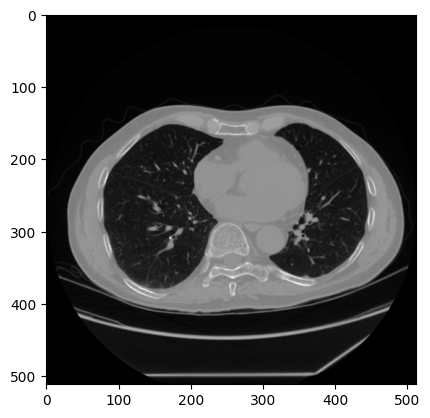

In [101]:
plt.figure()
plt.imshow(np.rot90(lung_ct_data_standardized[:,:,50]), cmap="gray")

# Windowing

În funcție de sarcina pe care o realizați, este necesar un contrast diferit. De exemplu, dacă doriți să inspectați plămânii, este important să puteți vizualiza toate vasele mici. În schimb, atunci când examinați corpul, este esențial să aveți un contrast ridicat pentru a putea diferenția între diferite țesuturi.

Această modificare a contrastului se numește fereastră de contrast (windowing). În mod obișnuit, există patru ferestre diferite: o fereastră pentru plămâni, una pentru oase, una pentru țesuturile moi și una pentru creier. O astfel de fereastră poate fi creată prin limitarea valorilor pixelilor care depășesc un anumit prag.

Să analizăm fereastra pentru plămâni și cea pentru țesuturile moi.

Pentru a obține o fereastră adecvată pentru plămâni, puteți limita toate valorile intre -1000 si -500. Este important de menționat că această fereastră nu permite examinarea abdomenului, deoarece toate structurile apar identic.

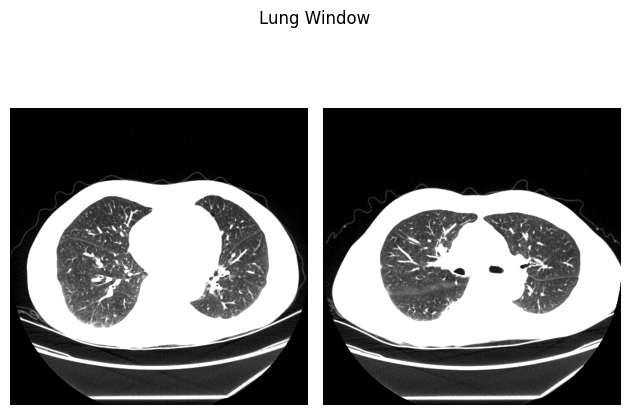

In [102]:
lung_ct_lung_window = np.clip(lung_ct_data, -1000, -500)

fig, axis = plt.subplots(1, 2)
axis[0].imshow(np.rot90(lung_ct_lung_window[:,:,50]), cmap="gray")
axis[1].imshow(np.rot90(lung_ct_lung_window[:,:,75]), cmap="gray")
axis[0].axis("off")
axis[1].axis("off")
fig.suptitle("Lung Window")
plt.tight_layout()
plt.savefig("lung_window.png", bbox_inches="tight")


3. Pentru a obține o fereastră adecvată pentru țesuturile moi, puteți limita toate valorile între -250 și 250. Aplicati transformarea si afisati 2 slice-uri ca in exemplul precedent.
Rezultatul ar trebui sa fie o imagine clară a abdomenului.

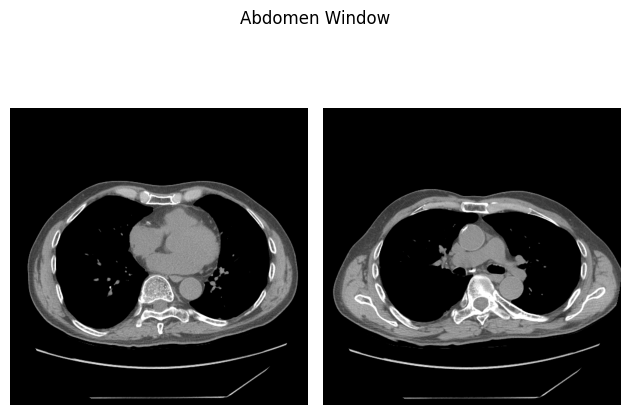

In [103]:
# TO DO 3
lung_ct_abdomen_window = np.clip(lung_ct_data, -250, 250)

fig, axis = plt.subplots(1, 2)
axis[0].imshow(np.rot90(lung_ct_abdomen_window[:,:,50]), cmap="gray")
axis[1].imshow(np.rot90(lung_ct_abdomen_window[:,:,75]), cmap="gray")
axis[0].axis("off")
axis[1].axis("off")
fig.suptitle("Abdomen Window")
plt.tight_layout()

4. Citiți fișierele DICOM din folderul Melanoma_Classification și afisati o diagrama care prezinta distri
butia pe gen. 

170
99 71


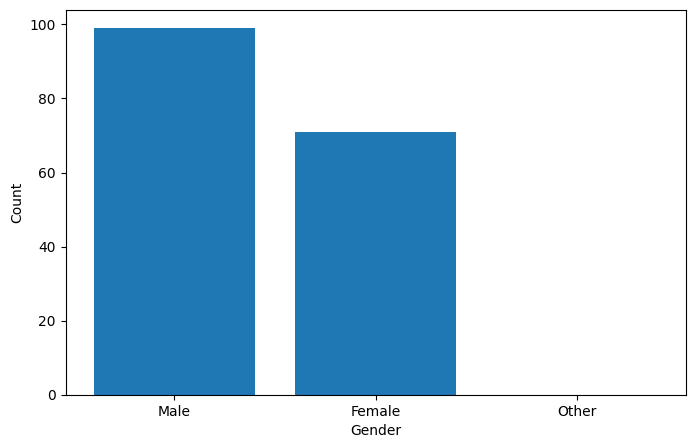

: 

In [116]:
path = Path("Melanoma_Classification")
slices = list(path.glob("*"))
print(len(slices))

gender = []
melanoma_dcm = []

for x in slices:
    dcm = pydicom.dcmread(x)
    melanoma_dcm.append(dcm)
    
    if "PatientSex" in dcm:
        gender.append(dcm.PatientSex)

male_count = gender.count("M")
female_count = gender.count("F")
other_count = len(gender) - male_count - female_count

plt.figure(figsize=(8, 5))
plt.bar(["Male", "Female", "Other"], [male_count, female_count, other_count])
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()
